In [42]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [43]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [44]:
train_data, test_data, train_y, test_y = train_test_split(data, labels, test_size=.2)

train_dataset = TensorDataset(train_data, train_y)
test_dataset = TensorDataset(test_data, test_y)

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=True)

In [45]:
def create_model():
    ANNiris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
    )
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005)
    
    return ANNiris, loss_fun, optimizer

In [46]:
temp_model = create_model()[0]

print(temp_model)
for i in temp_model.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [47]:
num_of_epochs = 1000

def train_model(model, loss_func, optimizer, l1_lambda):
    train_acc = []
    test_acc = [] 
    losses = []
    
    n_weights = 0
    for pname, weight in model.named_parameters():
        if "bias" not in pname:
            n_weights = n_weights + weight.numel()
            
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            l1_term = torch.tensor(0., requires_grad=True)
            
            for pname, weight in model.named_parameters():
                if "bias" not in pname:
                    l1_term = l1_term + torch.sum(torch.abs(weight))
                    
            loss = loss + l1_lambda*l1_term/n_weights
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()).item())
            batch_loss.append(loss.item())
            
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        
        model.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(model(X), axis=1)
        test_acc.append(100*torch.mean((predlabels==y).float()).item())
    
    return train_acc, test_acc, losses

In [48]:
l1_lambda = .001
ANNiris, loss_fun, optimizer = create_model()

train_acc, test_acc, losses = train_model(ANNiris, loss_fun, optimizer, l1_lambda)

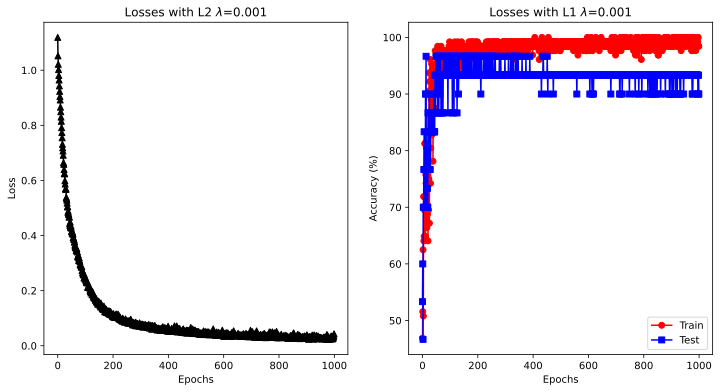

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$='+str(l1_lambda))

ax[1].plot(train_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Losses with L1 $\lambda$='+str(l1_lambda))
ax[1].legend(['Train', 'Test'])

plt.show()

In [50]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

In [52]:
l1_lambdas = np.linspace(0, .005, 10)

accuracy_results_train = np.zeros((num_of_epochs, len(l1_lambdas)))
accuracy_results_test = np.zeros((num_of_epochs, len(l1_lambdas)))


for idx, l1_lambda in enumerate(l1_lambdas):
    ANNiris, loss_fun, optimizer = create_model()

    train_acc, test_acc, losses = train_model(ANNiris, loss_fun, optimizer, l1_lambda)
    accuracy_results_train[:, idx] = smooth(train_acc, 10)
    accuracy_results_test[:, idx] = smooth(test_acc, 10)

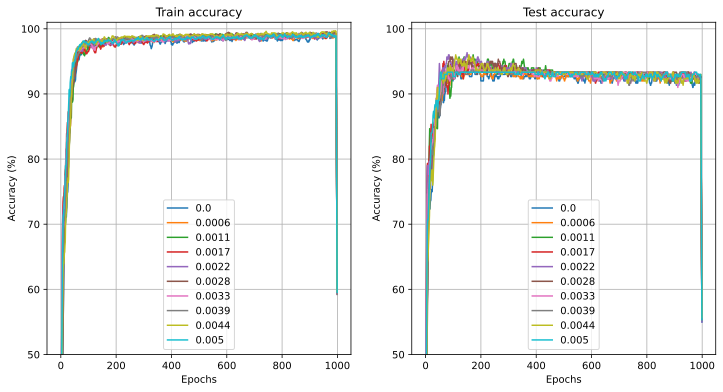

In [53]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

leg_labels = [np.round(i, 4) for i in l1_lambdas]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()
    
plt.show()

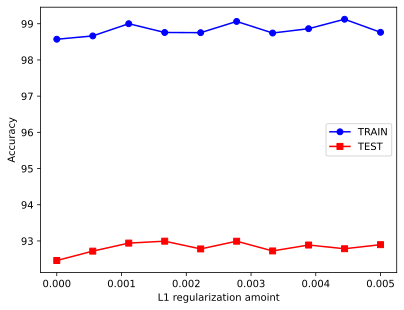

In [54]:
epochs_range = [500, 950]

plt.plot(l1_lambdas,
        np.mean(accuracy_results_train[epochs_range[0]: epochs_range[1], :],axis=0),
        'bo-', label='TRAIN')

plt.plot(l1_lambdas,
        np.mean(accuracy_results_test[epochs_range[0]: epochs_range[1], :],axis=0),
        'rs-', label='TEST')

plt.xlabel('L1 regularization amoint')
plt.ylabel('Accuracy')
plt.legend()
plt.show()